In [1]:
# TODO try to use the old mabexperiment code with this gym.env and the agents
# TODO make the same thing with classes karmedexperiment and karmedcompetition
# TODO think of implementing multicore version
# TODO create KPI % average loss per timestep
# runtimes for 1e6 iterations measured 20250206, 9 am
# @ThinkPad: 25.4s
# @ThinkPad old approach with 2 cores: 27.5s
# @ThinkPad old approach with 6 cores: 11.4s (only p-cores?)
# @ThinkPad old approach with 16 cores: 8.9s (p- and e-cores)

def ppt(feedback):
    print('-'*len(feedback))
    print(feedback)
    print('-'*len(feedback))

# training a basic agent

import gymnasium as gym
import numpy as np

from tqdm import tqdm
import karmedbandit
from karmedagents import BanditAgentEpsilonGreedyClaude, BanditAgentEpsilonGreedyOptimized

# Instantiate env
env = gym.make("BanditEnv-v0")
# env.random_seed = 42
obs, info = env.reset()

ppt(f'Initial bandit arms q-values:{env.get_wrapper_attr("arms_q_values")}')

# Instantiate agent
# agent = BanditAgentEpsilonGreedyClaude(env=env, epsilon=0.1, start_value=0.0, seed=42)
agent = BanditAgentEpsilonGreedyOptimized(env=env, epsilon=0.05, start_value=0.0, seed=42)
# ppt(f'Agent policy: {epsilon}')

# set up experiment
# episodes = 2000
# timesteps = 20000
episodes = 1000
timesteps = 1000

# Create arrays to collect KPI
average_rewards_all_runs = np.zeros(timesteps)
average_loss_all_runs = np.zeros(timesteps)
optimal_actions = np.zeros(timesteps)
percentage_optimal_actions = np.zeros(timesteps)

for episode in tqdm(range(episodes)):
    obs, info = env.reset()
    agent.reset()

    # Create arrays to collect episode KPI
    rewards_run = np.zeros(timesteps)
    loss_run = np.zeros (timesteps)

    for timestep in range(timesteps):  
        action = agent.get_action()
        obs, reward, terminated, truncated, info = env.step(action)
        agent.update(reward)
        # get, log KPI
        step_error, optimal_action = info.get('step_error'), info.get('optimal_action')
        rewards_run[timestep] = reward
        optimal_actions[timestep] += 1 if optimal_action else 0
        loss_run[timestep] = step_error
    
    # compute and log overall KPI
    average_rewards_all_runs += (rewards_run - average_rewards_all_runs) / (episodes + 1)
    average_loss_all_runs += (loss_run - average_loss_all_runs) / (episodes + 1)

percentage_optimal_actions = optimal_actions / episodes

ppt(f'Final bandit arms q-values:{env.get_wrapper_attr("arms_q_values")}')

# env.close()
# BanditAgentEpsilonGreedyClaude: 600k its: 21.7s
# BanditAgentEpsilonGreedyClaude: 600k its: 19.2s


-------------------------
Bandit configuration
-------------------------
bandit_actions: 10
true_q_value_mean: 0.0
true_q_value_std: 0.1
q_value_std: 0.0
q_drift_mean: 0.0
q_drift_std: 0.01
random_seed: None
-------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Initial bandit arms q-values:[ 0.03622628  0.23219019 -0.07821837 -0.0452315   0.08139396 -0.0263683
 -0.13315219  0.06036172  0.02583036  0.08873042]
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|██████████| 1000/1000 [00:39<00:00, 25.26it/s]

-----------------------------------------------------------------------------------------------------------------------------------------------------
Final bandit arms q-values:[-0.24991641  0.27922502  0.31072099 -0.64863167 -0.45130728  0.60078126
 -0.42983292 -0.01597843 -0.01028028  0.59388196]
-----------------------------------------------------------------------------------------------------------------------------------------------------


In [7]:
print(f'Initial bandit arms q-values:{env.get_wrapper_attr("arms_q_values")}')

Initial bandit arms q-values:[0.61777551 0.52438239 0.56544846 0.65989012 0.56517177 0.40821757
 0.35628955 0.42915176 0.47831443 0.66675912]


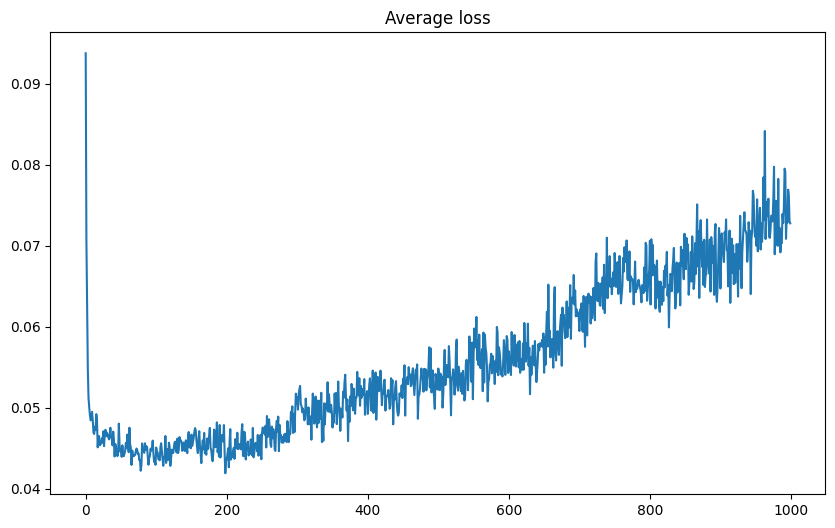

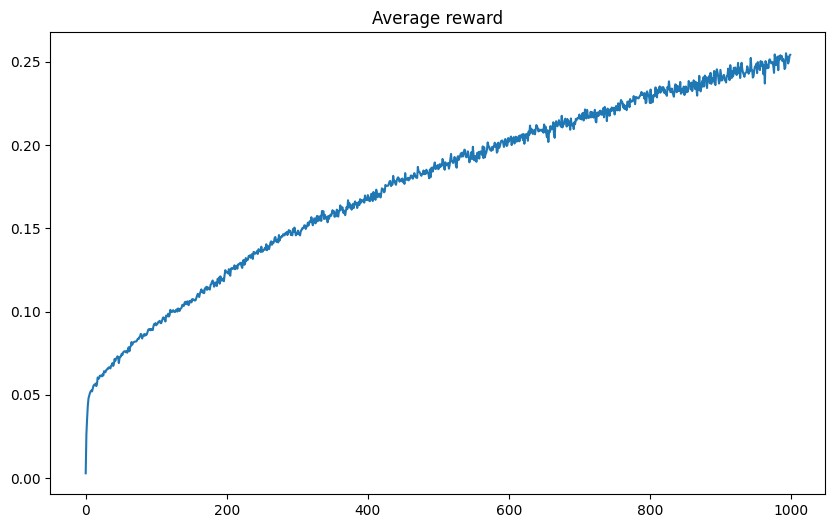

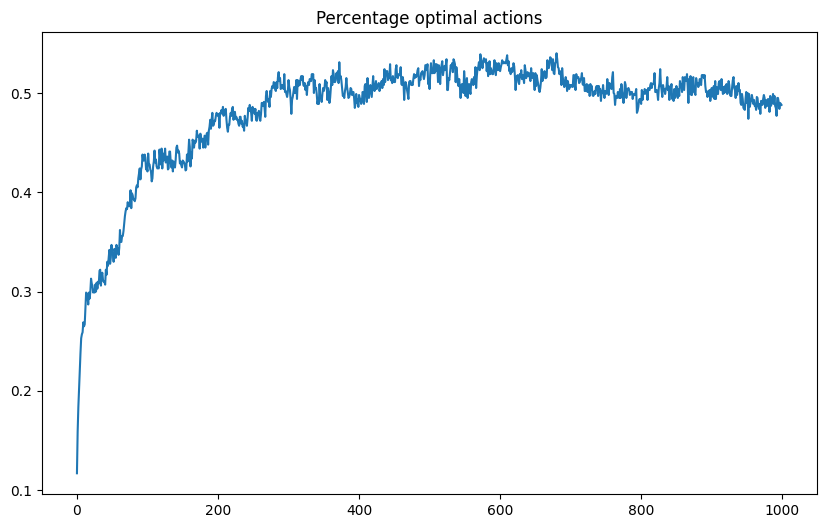

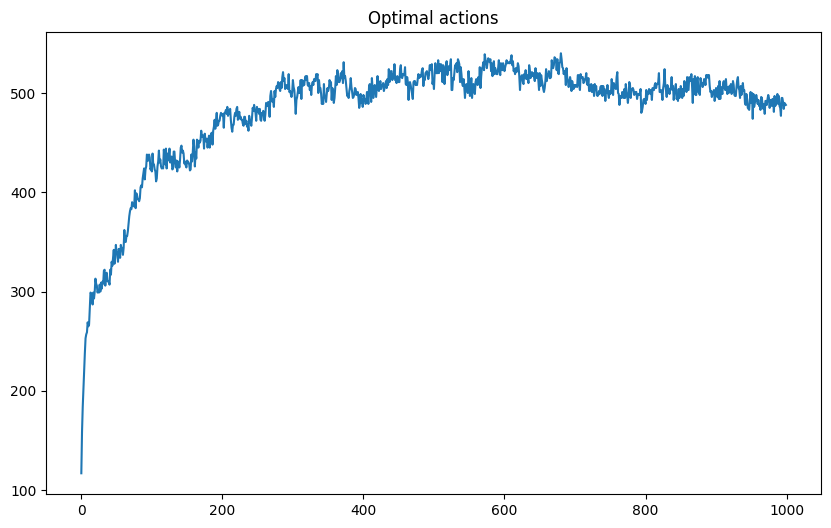

In [2]:
import matplotlib.pyplot as plt

# Dictionary of plot names and data
plots = {
    "Average loss": average_loss_all_runs,
    "Average reward": average_rewards_all_runs,
    "Percentage optimal actions": percentage_optimal_actions,
    "Optimal actions": optimal_actions
}

for plot_name, plot_data in plots.items():
    plt.figure(figsize=(10, 6))
    plt.title(plot_name)
    plt.plot(plot_data[:1000])
    plt.show()

In [ ]:
# testing whether the env instantiation and use works in .ipynb

from karmedbandit import BanditEnv
env = BanditEnv()

# XXX info: gymnasium env self test. Run as required.
# The output in the terminal will indicate whether tests passed or failed.
# check_env(env = env)

print(env.true_q_value_mean)
obs, info = env.reset()
print("Initial arms_q_values:", env.arms_true_q_values)
print ("#"*79)
for _ in range(10_000):  # Perform some steps
    action = env.action_space.sample() #Example
    obs, reward, terminated, truncated, info = env.step(action)

print("Updated arms_q_values:", np.round(env.arms_q_values, 3))

env.close()

In [ ]:
#testing the arms_true_q_values creation works properly
import numpy as np
bandit_actions = 10

bandit_actions: int = 10
true_q_value_mean = 0.5, # 
true_q_value_std = 0., # for a uniform initial q-value set this to zero

arms_true_q_values = np.random.normal(true_q_value_mean, true_q_value_std, bandit_actions)

print(arms_true_q_values)

In [ ]:
# testing the ingest of BanditParams into BanditEnv

import inspect

import gymnasium as gym

class BanditParams:
    arms: int = 10
    qdrift_mean: float = 0.0
    qdrift_std: float = 0.0
    stationary: bool = True

class BanditEnv(gym.Env, BanditParams):

    metadata = {"render_modes": ["human"], "render_fps": 4}
    
    def __init__(self):
        super().__init__()
        pass

env = BanditEnv()
# print(env.arms)
# env.arms = 6
# print(env.arms)

print(*[f"{key}: {value}" for key, value in env.__dict__.items()], sep="\n")

In [ ]:
# Testing a violin chart to represent a distribution

'''Figure 2.1: An example bandit problem from the 10-armed testbed. The true value q⇤(a) of
each of the ten actions was selected according to a normal distribution with mean zero and unit
variance, and then the actual rewards were selected according to a mean q⇤(a), unit-variance
normal distribution, as suggested by these gray distributions.'''

import matplotlib.pyplot as plt
import numpy as np

# Generate the data
arms = 10
arms_q_values = np.random.normal(0, 1, arms)
timesteps = 10000
arms_values_over_time = np.zeros(timesteps)

arm = np.min(arms_q_values)
for i in range(timesteps):
    arms_values_over_time[i] = np.random.normal(arm, 1)

# Create a violin plot based on the data in arms_values_over_time
plt.violinplot(arms_values_over_time)
plt.title('Violin Plot of Arms Values Over Time')
plt.xlabel('Arms')
plt.ylabel('Values')

# Calculate the mean of the distribution
mean_value = np.mean(arms_values_over_time)

# Add a shorter marker/error line for the mean of the distribution
plt.axhline(mean_value, color='r', linestyle='--', linewidth=1, xmin=0.45, xmax=0.55)

# Get the current axis
ax = plt.gca()

# Get the right end of the error line
xmax = ax.get_xlim()[1] * 0.55
print (xmax, ax.get_xlim()[1])

# Add text relative to the right end of the error line
plt.text(1.45 * xmax + 0.02 * ax.get_xlim()[1], mean_value, f'q({np.argmin(arms_q_values)})', color='r', verticalalignment='center')

# Show the plot
plt.show()